In [1]:
!pip install --upgrade albumentations -q
!pip install gdown

import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import ImageFile
import glob
import shutil
import cv2

from sklearn.datasets import load_files
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image  

import albumentations as A
from tensorflow.keras.models import Model
import tensorflow.keras.layers
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9681 sha256=98afc32304fa35aad45ede59734cc798f289f92b8682129414dfdbcd3c621aa8
  Stored in directory: /root/.cache/pip/wheels/ba/e0/7e/726e872a53f7358b4b96a9975b04e98113b005cd8609a63abc
Successfully built gdown


In [ ]:
def draw_plot_from_history(history, metric, n_epochs, stage):
    plt.style.use("ggplot")
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(0, n_epochs), history.history[metric], label="train_%s" % metric)
    if "val_%s" % metric in history.history:
        plt.plot(np.arange(0, n_epochs), history.history["val_%s" % metric], label="val_%s" % metric)
    title = metric
    plt.title(title)
    plt.xlabel("Epoch #")
    plt.ylabel("Value")
    plt.legend()
    filename = title + '.png'
    plt.show()

In [68]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, augmentation, image_size, shuffle=True):
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.image_size = image_size

        self.image_names = np.array([item['path'] for item in data])
        self.targets = to_categorical(np.array([int(item['label'][1:]) for item in data]))
        self.samples = len(self.targets)

        self.indexes = np.arange(self.samples)
        if shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(self.samples / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def transform_image(self, image):
        image = cv2.resize(image, (self.image_size, self.image_size), interpolation = cv2.INTER_CUBIC)

        if self.augmentation:
            image = self.augmentation(image=image)['image']

        return image

    def __getitem__(self, index):
        take_ind = self.indexes[index * self.batch_size: min((index + 1) * self.batch_size, len(self.targets))]
        X = np.empty((len(take_ind), self.image_size, self.image_size, 3))
        y = self.targets[take_ind, :]

        for i in range(len(take_ind)):
            img = cv2.imread(self.image_names[take_ind[i]], cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = self.transform_image(img)
            X[i] = img
            
        X = preprocess_input(X)

        return X, y

Create augmentations:

In [69]:
transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, 
                           p=0.5, border_mode=cv2.BORDER_CONSTANT), 
        A.RandomBrightnessContrast(p=0.5),
        A.RGBShift(p=0.25),
        A.GaussNoise(p=0.25),
        A.HorizontalFlip(p=0.5),
    ]
)

Create generators:

In [5]:
TRAIN_DIR = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"
TEST_DIR = "/kaggle/input/state-farm-distracted-driver-detection/imgs/test"

In [70]:
TEACHER_INPUT_SHAPE = 380
STUDENT_INPUT_SHAPE = 380
BATCH_SIZE = 32
num_classes = 10

In [89]:
train_data = []
label_stat = []

for label in os.listdir(TRAIN_DIR):
    for img_path in glob.glob(os.path.join(TRAIN_DIR, label, "*.jpg")):
        train_data.append({'path': img_path, 'label': label})
        label_stat.append(label)

train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=label_stat, shuffle=True)

train_generator = DataGenerator(train_data, BATCH_SIZE, transform, TEACHER_INPUT_SHAPE)
validation_generator = DataGenerator(val_data, BATCH_SIZE, None, TEACHER_INPUT_SHAPE, shuffle=False)

Build model:

In [91]:
class Distiller(keras.Model):
    def __init__(self, student, teacher, student_input_shape):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
        self.student_input_shape = student_input_shape

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [9]:
import gdown

# url = 'https://drive.google.com/u/0/uc?id=1c4y7kb-0OYmaTS9G_oLJRoKCMj6Qo-LI&export=download'
# output = 'student.zip'
# gdown.download(url, output, quiet=False)
# !unzip student.zip

url = 'https://drive.google.com/u/0/uc?id=1iMZeYCX-Qijk4iPL5AULQvt21LroUw3K&export=download'
output = 'teacher.zip'
gdown.download(url, output, quiet=False)
!unzip teacher.zip

Downloading...
From: https://drive.google.com/u/0/uc?id=1iMZeYCX-Qijk4iPL5AULQvt21LroUw3K&export=download
To: /kaggle/working/teacher.zip
85.2MB [00:00, 261MB/s]


Archive:  teacher.zip
  inflating: model1_stage2.hdf5      


In [79]:
student = MobileNetV2(weights='imagenet', include_top=False, 
                      input_shape=(STUDENT_INPUT_SHAPE, STUDENT_INPUT_SHAPE, 3))

for layer in student.layers:
    layer.trainable = False

x = student.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='linear')(x)

student = Model(inputs=student.input, outputs=predictions)
student._name = 'student'

In [74]:
teacher = load_model('model1_stage2.hdf5')

teacher_copy= tf.keras.models.clone_model(teacher)
teacher_copy.build(teacher.input_shape)
teacher_copy.set_weights(teacher.get_weights())

x = teacher_copy.layers[-2].output
predictions = Dense(num_classes, activation='linear')(x)
teacher_copy = Model(inputs=teacher_copy.input, outputs=predictions)
teacher_copy.layers[-1].set_weights(teacher.layers[-1].get_weights())

teacher = teacher_copy
teacher._name = 'teacher'

In [92]:
distiller = Distiller(student=student, teacher=teacher, student_input_shape=STUDENT_INPUT_SHAPE)

In [ ]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(INPUT_SHAPE, INPUT_SHAPE, 3)))
# model.add(BatchNormalization())
# model.add(Conv2D(64, kernel_size=3, activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(128, kernel_size=3, activation='relu'))
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(10, activation='softmax'))
# print(model.summary())

Warmup:

In [85]:
NUM_EPOCHS = 3
LEARNING_RATE = 0.001

In [94]:
distiller.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=[keras.metrics.CategoricalAccuracy()],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

history = distiller.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS, verbose=1)

Epoch 1/3
560/560 [==============================] - 489s 862ms/step - categorical_accuracy: 0.3427 - student_loss: 1.6151 - distillation_loss: 0.0121 - val_categorical_accuracy: 0.8085 - val_student_loss: 1.2390
Epoch 2/3
560/560 [==============================] - 375s 669ms/step - categorical_accuracy: 0.6807 - student_loss: 1.0630 - distillation_loss: 0.0154 - val_categorical_accuracy: 0.8542 - val_student_loss: 0.9484
Epoch 3/3
560/560 [==============================] - 375s 669ms/step - categorical_accuracy: 0.7557 - student_loss: 0.8870 - distillation_loss: 0.0178 - val_categorical_accuracy: 0.8848 - val_student_loss: 0.7481


KeyError: 'loss'

<Figure size 648x360 with 0 Axes>

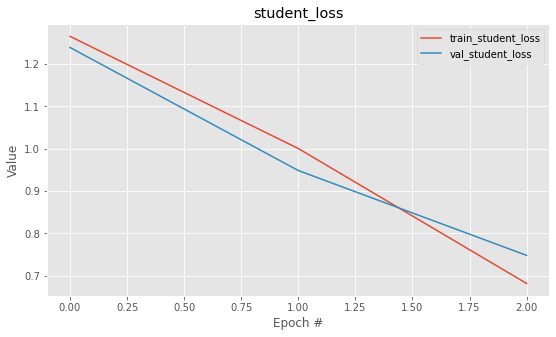

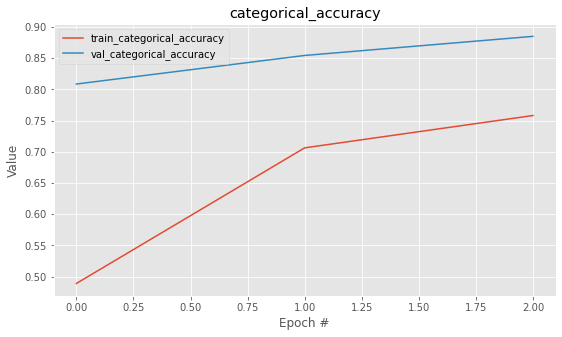

In [99]:
draw_plot_from_history(history, 'student_loss', NUM_EPOCHS, 'STAGE_1')
draw_plot_from_history(history, 'categorical_accuracy', NUM_EPOCHS, 'STAGE_1')

In [103]:
distiller.save_weights("model_distill_stage1.hdf5")

Unfreezeing deeper layers:

In [104]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.0003
FINE_TUNE_FROM_LAYER = -20

In [105]:
for layer in distiller.layers:
    layer.trainable = False
for layer in distiller.layers[FINE_TUNE_FROM_LAYER:]:
    if not isinstance(layer, tensorflow.keras.layers.BatchNormalization):
        layer.trainable = True

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
560/560 [==============================] - 464s 811ms/step - categorical_accuracy: 0.8551 - student_loss: 0.2747 - distillation_loss: 0.0246 - val_categorical_accuracy: 0.8440 - val_student_loss: 0.4224

Epoch 00001: val_student_loss improved from inf to 0.42235, saving model to model_distill_stage2.hdf5
Epoch 2/30
560/560 [==============================] - 450s 803ms/step - categorical_accuracy: 0.9875 - student_loss: 0.1170 - distillation_loss: 0.0205 - val_categorical_accuracy: 0.9877 - val_student_loss: 0.1773

Epoch 00002: val_student_loss improved from 0.42235 to 0.17733, saving model to model_distill_stage2.hdf5
Epoch 3/30
560/560 [==============================] - 452s 807ms/step - categorical_accuracy: 0.9933 - student_loss: 0.0924 - distillation_loss: 0.0195 - val_categorical_accuracy: 0.9877 - val_student_loss: 0.1209

Epoch 00003: val_student_loss improved from 0.17733 to 0.12091, saving model to model_distill_stage2.hdf5
Epoch 4/30
560/560 [=====================

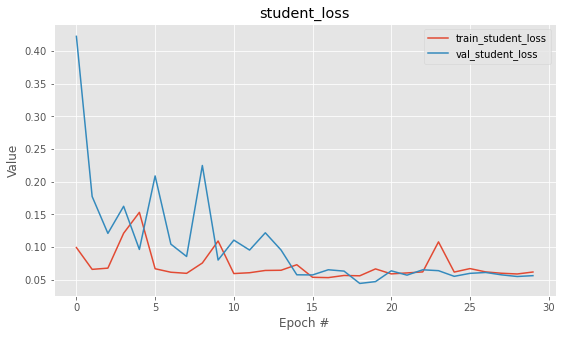

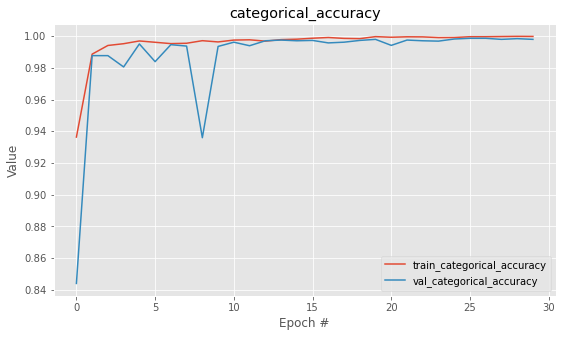

In [106]:
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=NUM_EPOCHS * train_generator.samples // BATCH_SIZE,
    end_learning_rate=LEARNING_RATE / 10,
    power=1.0)

distiller.compile(
    optimizer=Adam(learning_rate=learning_rate_fn),
    metrics=[keras.metrics.CategoricalAccuracy()],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

save_best_checkpoint = ModelCheckpoint("model_distill_stage2.hdf5", verbose=1, 
                                       monitor='val_student_loss', save_best_only=True, mode='auto')

history = distiller.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    callbacks=[save_best_checkpoint], 
    verbose=1)

draw_plot_from_history(history, 'student_loss', NUM_EPOCHS, 'STAGE_2')
draw_plot_from_history(history, 'categorical_accuracy', NUM_EPOCHS, 'STAGE_2')

In [107]:
def save_plot_from_history(history, metric, n_epochs, stage):
    plt.style.use("ggplot")
    plt.figure(figsize=(21, 15))
    plt.plot(np.arange(0, n_epochs), history.history[metric], label="train_%s" % metric)
    if "val_%s" % metric in history.history:
        plt.plot(np.arange(0, n_epochs), history.history["val_%s" % metric], label="val_%s" % metric)
    title = metric
    plt.title(title, fontsize=18)
    plt.xlabel("Epoch #", fontsize=18)
    plt.ylabel("Value", fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    filename = title + '.png'
    plt.savefig(filename)

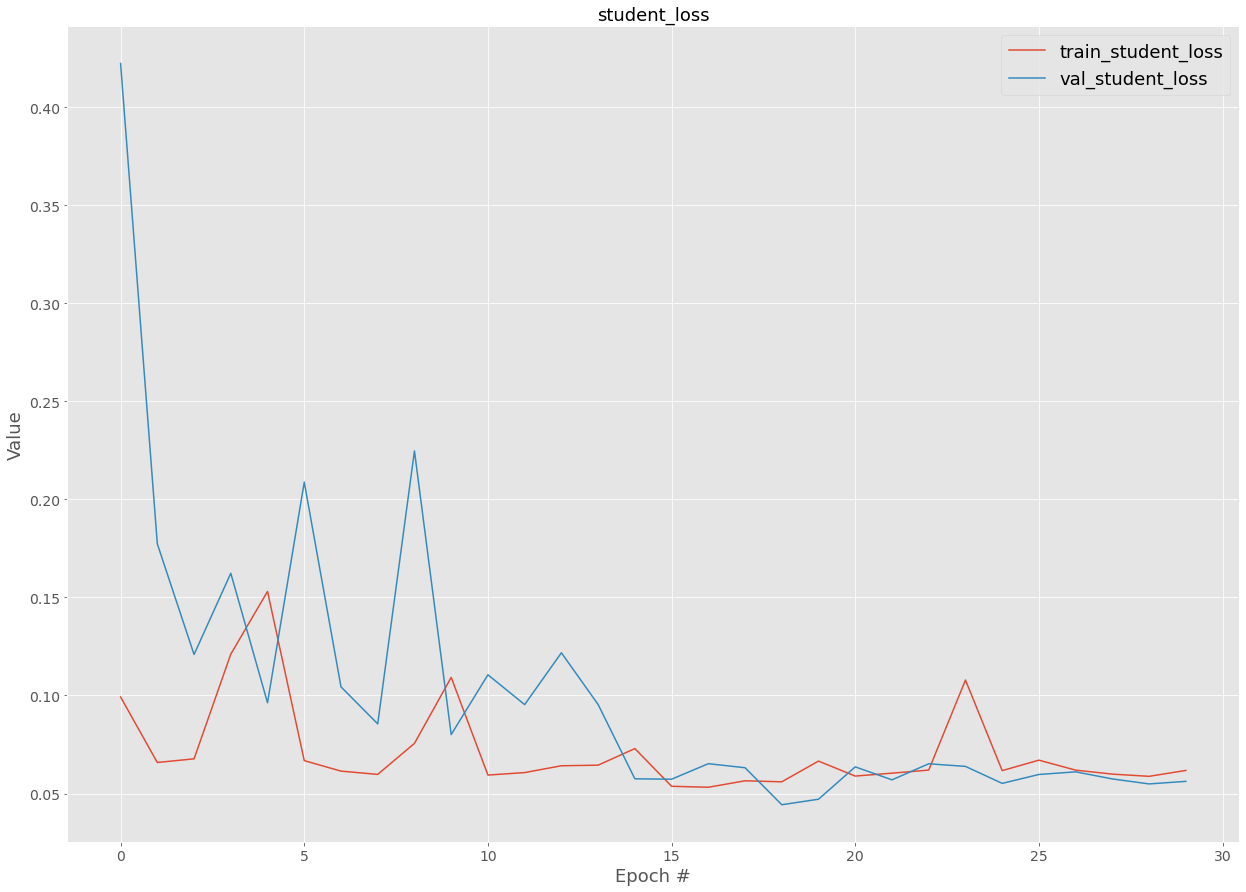

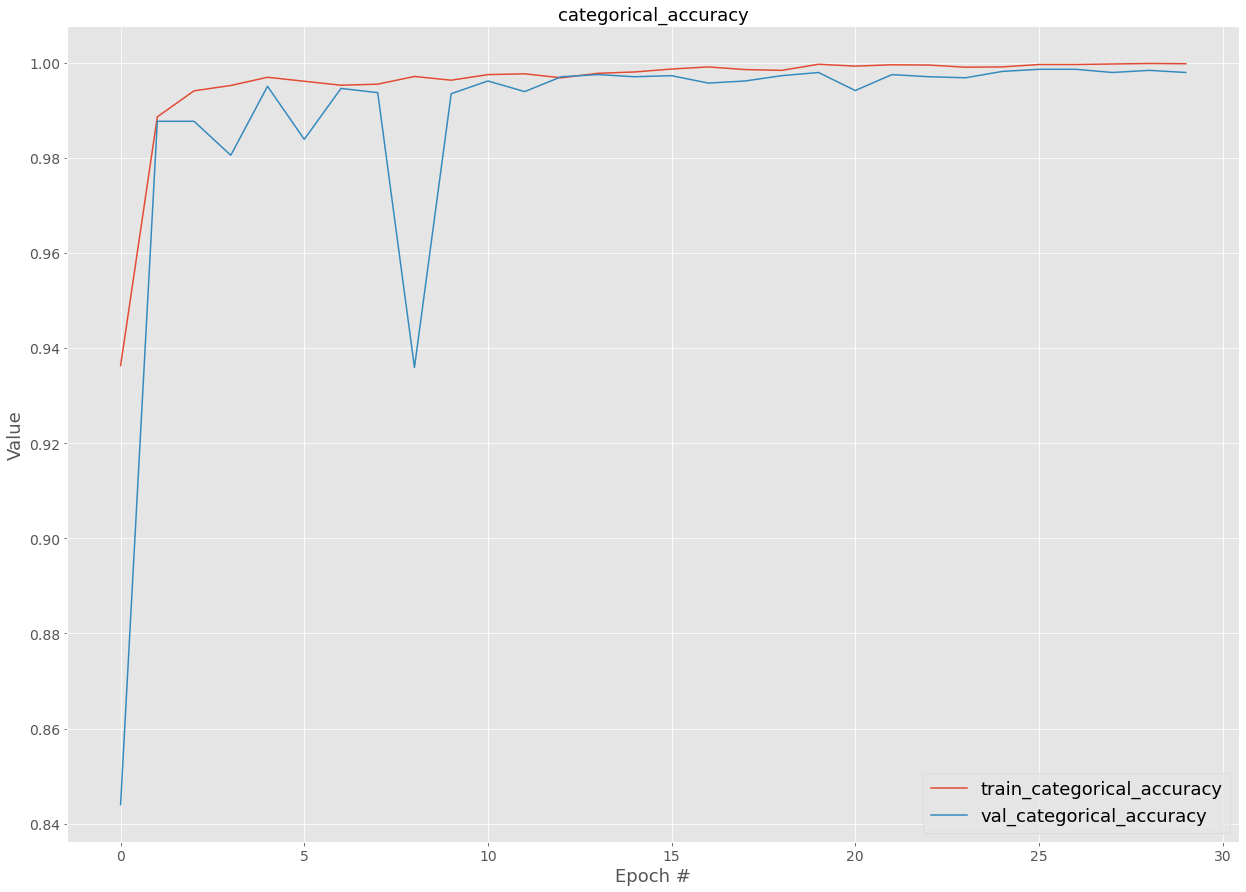

In [109]:
save_plot_from_history(history, 'student_loss', NUM_EPOCHS, 'STAGE_2')
save_plot_from_history(history, 'categorical_accuracy', NUM_EPOCHS, 'STAGE_2')

Make predictions:

In [145]:
class DistillerNew(Distiller):
    def __init__(self, student, teacher, student_input_shape):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
        self.student_input_shape = student_input_shape

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

   
    def __call__(self, x, training=False):

        # Compute predictions
        y_prediction = self.student(x, training=False)

        return y_prediction

In [119]:
from tqdm.auto import tqdm


INPUT_SHAPE = 380

In [124]:
def classify(model, test_img_dir):

    result = dict()
    keys = ['name', *['c%d' % i for i in range(10)]]
    for key in keys:
        result[key] = []
        
    paths = sorted(list(os.listdir(test_img_dir)))

    for path in tqdm(paths):
        if not path.endswith('.jpg'):
            continue
        
        image = cv2.imread(os.path.join(test_img_dir, path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (INPUT_SHAPE, INPUT_SHAPE), interpolation = cv2.INTER_CUBIC)

        pred = model.predict(np.expand_dims(image, 0))[0]
        result['name'].append(path)
        for i in range(10):
            result['c%d' % i].append(pred[i])

    return result

In [117]:
# model = tf.keras.models.clone_model(distiller)
distiller.load_weights('model_distill_stage2.hdf5')

In [128]:
a = distiller.get_weights()

In [148]:
# mod = DistillerNew(student, teacher, 380)
# mod.set_weights(a)

teached_student = distiller.student

In [150]:
teached_student.save('distill_stage2.hdf5')

In [151]:
result = classify(teached_student, TEST_DIR)

  0%|          | 0/79726 [00:00<?, ?it/s]

In [164]:
res_zip = np.array(list(zip(*[result['c%d' % i] for i in range(10)])))
res_zip = np.exp(res_zip)
res_zip /= np.sum(res_zip, axis=1, keepdims=True)
res_zip.sum(axis=1)

array([1.0000001 , 1.0000001 , 1.        , ..., 0.99999994, 1.0000001 ,
       0.99999994], dtype=float32)

In [173]:
from copy import deepcopy

In [174]:
res_zip = list(zip(*res_zip.tolist()))
result_softmax = deepcopy(result)

for i in range(10):
    result_softmax['c%d' % i] = res_zip[i]

In [176]:
dct = {'img': result_softmax['name']}
for i in range(10):
    col = 'c%d' % i
    dct[col] = result_softmax[col]
    
df = pd.DataFrame(dct)
df.to_csv('submission.csv', index=False)
df

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.026882,0.028237,0.005781,0.017808,0.009810,0.023618,0.046358,0.687840,0.045182,0.108484
1,img_10.jpg,0.024610,0.023935,0.007132,0.019827,0.013893,0.034261,0.046421,0.677480,0.047809,0.104633
2,img_100.jpg,0.053465,0.044679,0.014135,0.033193,0.022140,0.052145,0.068300,0.544218,0.064701,0.103025
3,img_1000.jpg,0.015272,0.007579,0.002074,0.006808,0.003268,0.006327,0.012430,0.918362,0.011109,0.016770
4,img_100000.jpg,0.028239,0.019632,0.005284,0.016571,0.011716,0.024883,0.030391,0.792871,0.032815,0.037597
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,0.019247,0.016752,0.003515,0.011832,0.006974,0.012657,0.021971,0.853584,0.023544,0.029923
79722,img_99995.jpg,0.092189,0.064840,0.016858,0.049565,0.035227,0.057640,0.078663,0.346175,0.086434,0.172407
79723,img_99996.jpg,0.050740,0.046193,0.015206,0.028768,0.020939,0.034437,0.054648,0.615148,0.070499,0.063422
79724,img_99998.jpg,0.040497,0.039301,0.011855,0.026758,0.018679,0.034906,0.052041,0.634431,0.063448,0.078084


Improve score a bit with clipping hack:

In [179]:
df_new = df.copy()

cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
arr, names = df_new.values[:, 1:], df_new.values[:, 0]
arr = np.clip(arr, 0.025, 0.975)
arr /= np.sum(arr, axis=1, keepdims=True)

new_df = pd.DataFrame(np.hstack([names.reshape((-1, 1)), arr]), columns=df.columns)
new_df.to_csv('submission_new.csv', index=False)
new_df

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.0257745,0.0270732,0.0239697,0.0239697,0.0239697,0.0239697,0.0444476,0.659493,0.0433199,0.104013
1,img_10.jpg,0.0241405,0.0241405,0.0241405,0.0241405,0.0241405,0.0330832,0.0448252,0.654188,0.046165,0.101036
2,img_100.jpg,0.0527414,0.0440736,0.0246615,0.0327434,0.0246615,0.0514388,0.067375,0.53685,0.0638249,0.10163
3,img_1000.jpg,0.0218653,0.0218653,0.0218653,0.0218653,0.0218653,0.0218653,0.0218653,0.803212,0.0218653,0.0218653
4,img_100000.jpg,0.0269736,0.0238797,0.0238797,0.0238797,0.0238797,0.0238797,0.0290291,0.757341,0.031345,0.0359124
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,0.0230732,0.0230732,0.0230732,0.0230732,0.0230732,0.0230732,0.0230732,0.787797,0.0230732,0.0276171
79722,img_99995.jpg,0.0914449,0.0643162,0.0247981,0.0491649,0.034943,0.0571747,0.0780274,0.34338,0.0857361,0.171015
79723,img_99996.jpg,0.0500462,0.0455619,0.0246584,0.028375,0.0246584,0.0339666,0.0539008,0.606741,0.069536,0.0625557
79724,img_99998.jpg,0.039724,0.0385501,0.0245226,0.0262471,0.0245226,0.0342392,0.0510477,0.622317,0.0622366,0.0765932
